**1. Loading libraries**

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import mstats
from statsmodels.stats.proportion import proportions_ztest

**2. Read data**

In [101]:
control_data = pd.read_csv('control_group.csv', sep = ";")
control_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
test_data = pd.read_csv('test_group.csv', sep = ";")
test_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


**3. Data processing**

In [103]:
control_data['Date'] = pd.to_datetime(control_data['Date'], dayfirst=True)
test_data['Date'] = pd.to_datetime(test_data['Date'], dayfirst=True)

1. Rename columns

In [104]:
control_data.columns = ['campaign_name', 'date', 'spend_usd',
                        'impressions', 'reach', 'clicks',
                        'searches', 'content_views', 'add_to_cart',
                        'purchases']
test_data.columns = ['campaign_name', 'date', 'spend_usd',
                        'impressions', 'reach', 'clicks',
                        'searches', 'content_views', 'add_to_cart', 
                        'purchases']

2. Missing values

In [105]:
print("Пропущенные значения в контрольной группе:")
print(control_data.isnull().sum())

Пропущенные значения в контрольной группе:
campaign_name    0
date             0
spend_usd        0
impressions      1
reach            1
clicks           1
searches         1
content_views    1
add_to_cart      1
purchases        1
dtype: int64


In [106]:
control_data.iloc[:, 3:] = control_data.iloc[:, 3:].fillna(control_data.iloc[:, 3:].median())

In [107]:
print("Пропущенные значения в тестовой группе:")
print(test_data.isnull().sum())

Пропущенные значения в тестовой группе:
campaign_name    0
date             0
spend_usd        0
impressions      0
reach            0
clicks           0
searches         0
content_views    0
add_to_cart      0
purchases        0
dtype: int64


3. Outliers

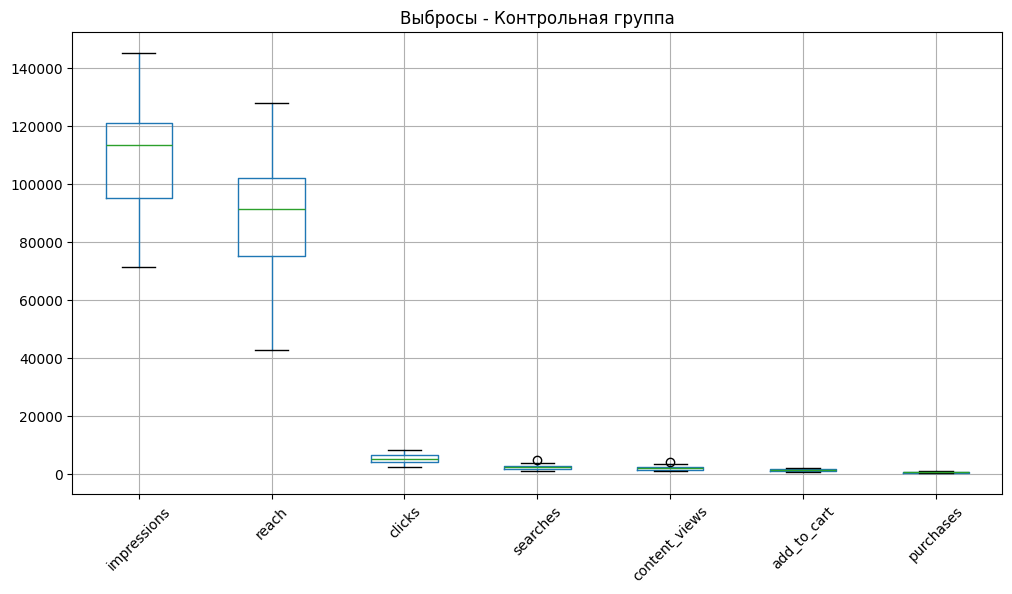

Найдено выбросов: 1


In [108]:
num_columns = control_data.columns[3:]

plt.figure(figsize=(12,6))
control_data[num_columns].boxplot()
plt.title('Выбросы - Контрольная группа')
plt.xticks(rotation=45)
plt.show()

Q1 = control_data[num_columns].quantile(0.25)
Q3 = control_data[num_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((control_data[num_columns] < (Q1 - 1.5 * IQR)) | 
            (control_data[num_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Найдено выбросов: {outliers.sum()}")

In [109]:
df_clean = control_data[~outliers]

control_data['clicks'] = mstats.winsorize(control_data['clicks'], limits=[0.05, 0.05])

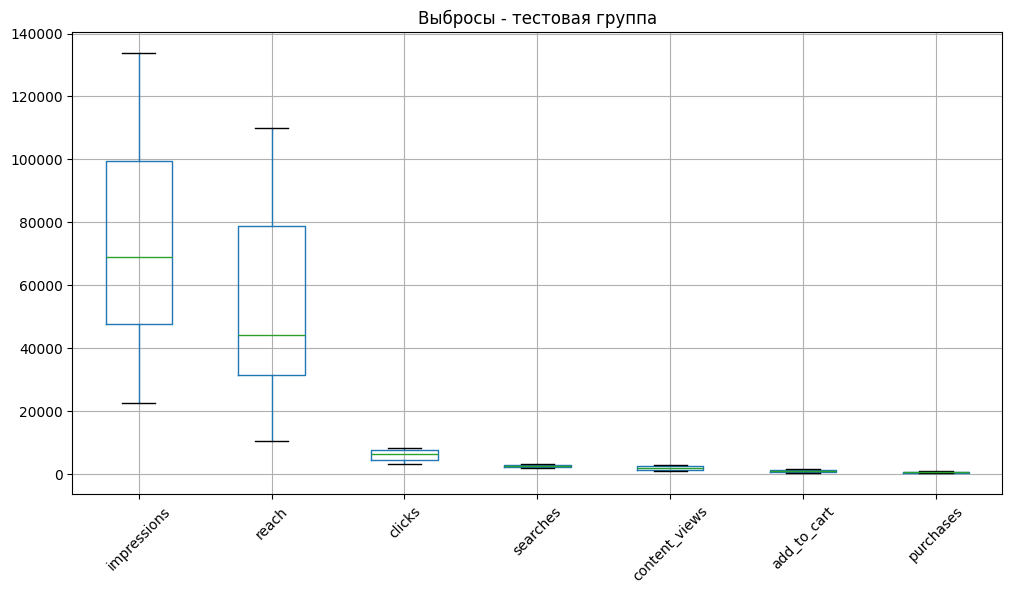

Найдено выбросов: 0


In [110]:
num_columns = test_data.columns[3:]

plt.figure(figsize=(12,6))
test_data[num_columns].boxplot()
plt.title('Выбросы - тестовая группа')
plt.xticks(rotation=45)
plt.show()

Q1 = test_data[num_columns].quantile(0.25)
Q3 = test_data[num_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((test_data[num_columns] < (Q1 - 1.5 * IQR)) | 
            (test_data[num_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Найдено выбросов: {outliers.sum()}")

In [111]:
df_clean = test_data[~outliers]

test_data['clicks'] = mstats.winsorize(test_data['clicks'], limits=[0.05, 0.05])

4. Data consistency

In [112]:
print("Отрицательные значения:")
print((control_data[num_columns] < 0).sum())

print("Кликов больше чем показов:")
print((control_data['clicks'] > control_data['impressions']).sum())

print("Покупок больше чем добавлений в корзину:")
print((control_data['purchases'] > control_data['add_to_cart']).sum())

Отрицательные значения:
impressions      0
reach            0
clicks           0
searches         0
content_views    0
add_to_cart      0
purchases        0
dtype: int64
Кликов больше чем показов:
0
Покупок больше чем добавлений в корзину:
1


In [113]:
outliers_cart_control = control_data[control_data['purchases'] > control_data['add_to_cart']]

print("Строки в контрольной группе, где покупок больше, чем добавлений в корзину:")
display(outliers_cart_control)

Строки в контрольной группе, где покупок больше, чем добавлений в корзину:


,campaign_name,date,spend_usd,impressions,reach,clicks,searches,content_views,add_to_cart,purchases
29,Control Campaign,2019-08-30,2324,111306.0,88632.0,4658.0,1615.0,1249.0,442.0,670.0


In [114]:
control_data.loc[control_data['purchases'] > control_data['add_to_cart'], 'purchases'] = control_data['add_to_cart']

**4. Calculate metrics**

1. Merge datasets

In [115]:
control_data['CTR'] = control_data['clicks'] / control_data['impressions'] * 100
control_data['CR'] = control_data['purchases'] / control_data['clicks'] * 100

test_data['CTR'] = test_data['clicks'] / test_data['impressions'] * 100
test_data['CR'] = test_data['purchases'] / test_data['clicks'] * 100

In [116]:
control_metrics = control_data.agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'purchases': 'sum',
    'CTR': 'mean',
    'CR': 'mean'
}).to_frame('Control')

test_metrics = test_data.agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'purchases': 'sum',
    'CTR': 'mean',
    'CR': 'mean'
}).to_frame('Test')

results = pd.concat([control_metrics, test_metrics], axis=1)
results['Difference'] = results['Test'] - results['Control']
results['Lift (%)'] = (results['Test'] - results['Control']) / results['Control'] * 100

2. CTR (Click-Through Rate)

In [117]:
clicks_control = control_data['clicks'].sum()
impressions_control = control_data['impressions'].sum()

clicks_test = test_data['clicks'].sum()
impressions_test = test_data['impressions'].sum()

count = [clicks_test, clicks_control]
nobs = [impressions_test, impressions_control]
z_stat, p_value_ctr = proportions_ztest(count, nobs)

3. CR (Conversion Rate)

In [118]:
purchases_control = control_data['purchases'].sum()
purchases_test = test_data['purchases'].sum()

count = [purchases_test, purchases_control]
nobs = [clicks_test, clicks_control]
z_stat, p_value_cr = proportions_ztest(count, nobs)

**5. Visualising**

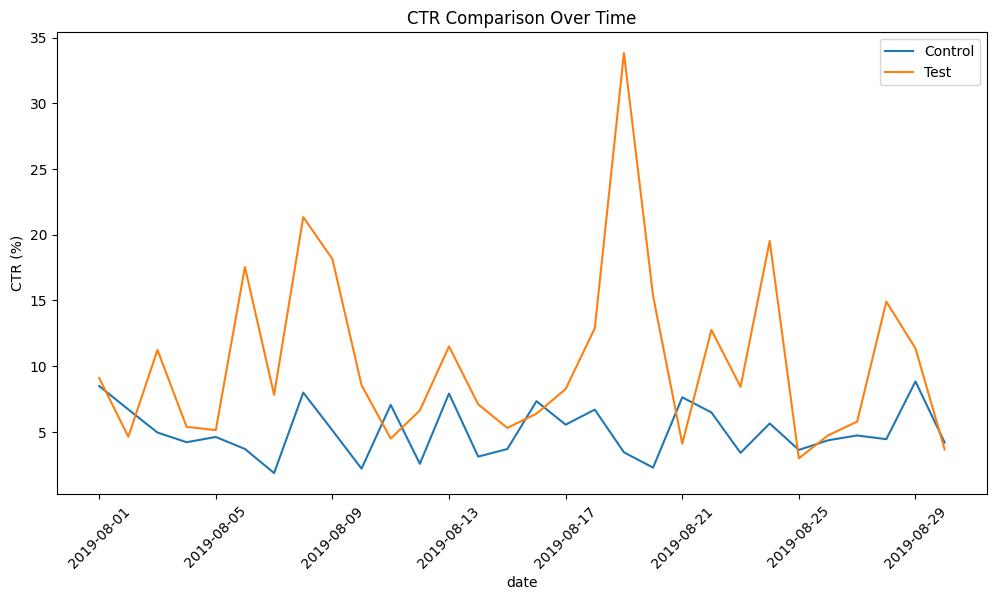

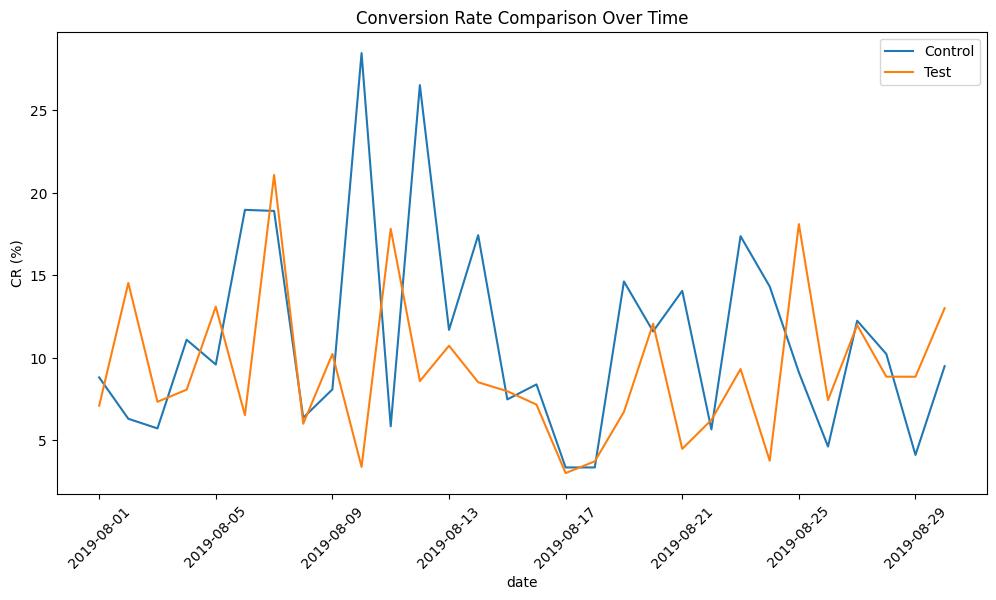

In [119]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=control_data, x='date', y='CTR', label='Control')
sns.lineplot(data=test_data, x='date', y='CTR', label='Test')
plt.title('CTR Comparison Over Time')
plt.ylabel('CTR (%)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=control_data, x='date', y='CR', label='Control')
sns.lineplot(data=test_data, x='date', y='CR', label='Test')
plt.title('Conversion Rate Comparison Over Time')
plt.ylabel('CR (%)')
plt.xticks(rotation=45)
plt.show()

In [120]:
display(results.style.format({
    'Control': '{:,.2f}',
    'Test': '{:,.2f}',
    'Difference': '{:,.2f}',
    'Lift (%)': '{:,.2f}%'
}))

,Control,Test,Difference,Lift (%)
impressions,"3,290,663.00","2,237,544.00","-1,053,119.00",-32.00%
clicks,"159,818.00","181,523.00","21,705.00",13.58%
purchases,"15,434.00","15,637.00",203.00,1.32%
CTR,5.09,10.29,5.20,102.23%
CR,11.13,9.19,-1.94,-17.42%
